# Machine Leraning Algorithms

**Imports**

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
import pandas as pd

**Reading the DataFrame**

In [2]:
df = pd.read_csv("final_modified_players.csv")

<br/>
<br/>

* Function to print model results

In [3]:
def print_results(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    precision = precision_score(y_test, y_pred)
    print(f'Precision: {precision}')

    recall = recall_score(y_test, y_pred)
    print(f'Recall: {recall}')

    f1 = f1_score(y_test, y_pred)
    print(f'F1-score: {f1}')

<br/>
<br/>


**Finding Best K for KNN**

In [4]:
def find_best_k_for_KNN(X_train, y_train):
    parameters = {'n_neighbors': list(range(1, 64))}
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters, scoring=make_scorer(metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_K = clf.best_params_["n_neighbors"]
    return best_K, clf.best_score_

In [5]:
# Split data into training and test sets
X = df.drop('Hall Of Famer', axis=1)
y = df['Hall Of Famer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Find the best value of k
best_k, best_score = find_best_k_for_KNN(X_train, y_train)
print(f'Best k value: {best_k}')
print(f'Best cross-validated F1-score: {best_score}')

Best k value: 16
Best cross-validated F1-score: 0.4816410256410257


**KNN Model**

In [6]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [7]:
print_results(y_test, y_pred)

Accuracy: 0.9763071895424836
Precision: 0.7142857142857143
Recall: 0.39473684210526316
F1-score: 0.5084745762711864


<br/>
<br/>

**Decision Tree Algorithm without scaler**

In [8]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

In [9]:
print_results(y_test, y_pred)

Accuracy: 0.9771241830065359
Precision: 0.6086956521739131
Recall: 0.7368421052631579
F1-score: 0.6666666666666666


<br/>
<br/>


**Handling binary imbalance calssification using <span style="color:green">SMOTE**</span>

In [10]:
# Separate the features and the target variable
X = df.drop('Hall Of Famer', axis=1)
y = df['Hall Of Famer']

# Create a SMOTE object with a 70/30 ratio
sm = SMOTE(random_state=0, sampling_strategy=0.2)

# Fit the SMOTE object to the data
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check the new class distribution
print(pd.Series(y_resampled).value_counts())

Hall Of Famer
False    3943
True      788
Name: count, dtype: int64


<br/>
<br/>

**Logistic Regression**
* Using logistic regression algorithim with <span style="color:blue">**scaler**</span>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print_results(y_test, y_pred)

Accuracy: 0.9640845070422536
Precision: 0.9137931034482759
Recall: 0.8724279835390947
F1-score: 0.8926315789473684


<br/>


<span style="font-size: 16px">**Checking the impact of <span style="color: blue; font-weight: bold;">Total Points</span> on Hall Of Fame chance**</span>
* Using permutation importance to check how important is total points column for the prediction of hall of famer. The value we got means that the prediction was around **12% worse without total points column.**

In [13]:
# Compute permutation importance
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10)

feature_index = X.columns.get_loc('Total Points')

print(f'Total Points: {result.importances_mean[feature_index]:.3f} +/- {result.importances_std[feature_index]:.3f}')

Total Points: 0.121 +/- 0.006


<br/>
<br/>

**Decision Tree with Scaler**

In [14]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)

y_pred = dt.predict(X_test_scaled)
print_results(y_test, y_pred)

Accuracy: 0.967605633802817
Precision: 0.8893280632411067
Recall: 0.9259259259259259
F1-score: 0.9072580645161291


<Axes: title={'center': 'Feature Importance'}>

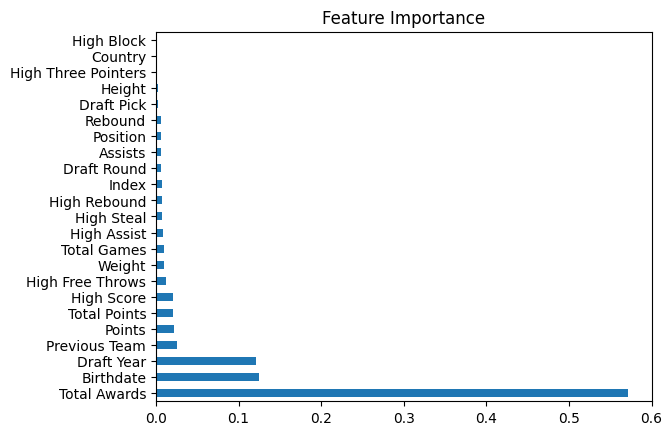

In [32]:
importance = dt.feature_importances_
importance_series = pd.Series(importance, index=X.columns)
sorted_importance = importance_series.sort_values(ascending=False)
sorted_importance.plot(kind='barh', title='Feature Importance')

<br/>
<br/>

**Cross Validation**
* Using 5-fold cross validation to confirm that there is no over-fitting in our model
* As you can see the deviation is very small, which means that there is probably no overfitting and the model is performing well.

In [56]:
model = LogisticRegression(max_iter=10000)

# Perform 5-fold cross-validation
scores = cross_validate(model, X_resampled, y_resampled, cv=5,
                        scoring=['accuracy', 'precision', 'recall', 'f1'])

# Print the mean scores and the 95% confidence intervals
for metric in scores.keys():
    if metric.startswith('test_'):
        mean = scores[metric].mean()
        std = scores[metric].std()
        print(f'{metric[5:]}: {mean:.2f} (+/- {std * 2:.2f})')

accuracy: 0.95 (+/- 0.02)
precision: 0.86 (+/- 0.07)
recall: 0.85 (+/- 0.08)
f1: 0.85 (+/- 0.06)
